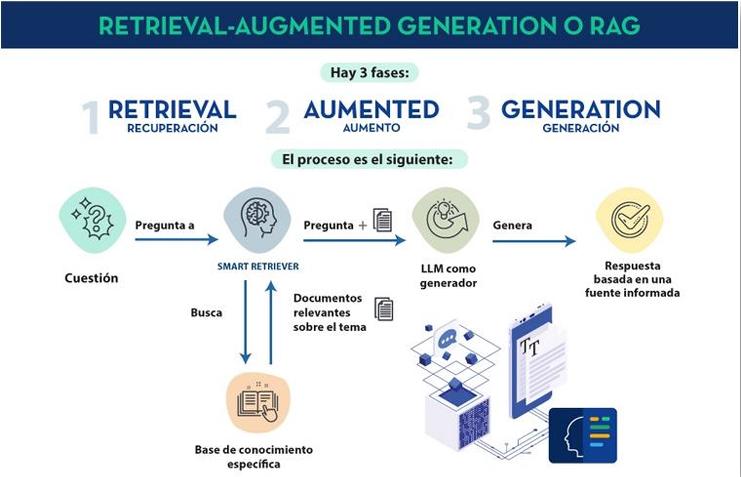

Más específicamente:

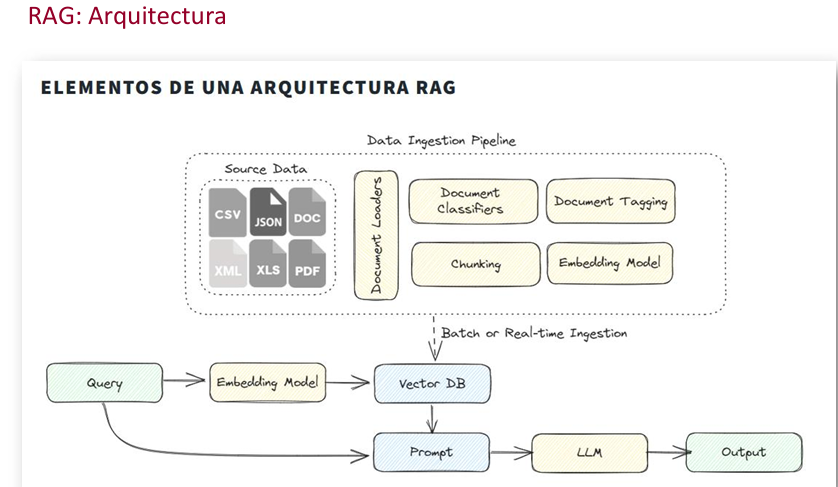

**EJEMPLOS DESTACADOS DE POSISBLES USOS**

**Sistemas de Gestión de Conocimiento:** Facilitan la búsqueda y recuperación de información dentro de organizaciones, como documentos corporativos o bases de datos académicas.

**E-Commerce:** Mejoran la experiencia de compra en línea al permitir a los clientes encontrar productos específicos.

In [ ]:
!pip install -U chromadb tiktoken openai langchain langchain-chroma langchain-community langchain-openai python-dotenv

from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain.embeddings import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema.runnable import RunnableMap
from langchain.schema.output_parser import StrOutputParser

!pip install unstructured
!pip install "unstructured[docx]"
!pip install "unstructured[pdf]"
from langchain_community.document_loaders import UnstructuredFileLoader

In [5]:
from IPython.display import display, HTML, Javascript

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importar librerías necesarias
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
urls = []  # Lista vacía
# Definir la ruta del directorio en MyDrive que deseas listar (puedes modificarlo)
folder_path = '/content/drive/MyDrive'

# Listar todos los archivos en el directorio (excluyendo subdirectorios, si se desea)
all_items = os.listdir(folder_path)
files = [f for f in all_items if os.path.isfile(os.path.join(folder_path, f))]
 #Mostrar leyenda visual para el usuario
display(HTML("<p style='color: red; font-weight: bold;'>Apriete [ESC] para terminar la selección de archivos de trabajo.</p>"))
# Crear un widget Dropdown para seleccionar el archivo
dropdown = widgets.Dropdown(
    options=files,
    description='Archivo:',
    disabled=False,
    style={'description_width': 'initial'}
)

# Botón para abrir el archivo seleccionado
button = widgets.Button(
    description="Click para adicionar su selección a la lista",
    button_style='info'  # Esto le da un fondo azul claro
)

# Área de salida para mostrar el contenido del archivo
output = widgets.Output()

def on_button_click(b):
    with output:
        #clear_output()  # Limpiar salida anterior
        filename = dropdown.value
        file_path = os.path.join(folder_path, filename)
        print(file_path)
        urls.append(file_path)


button.on_click(on_button_click)

# Capturar la tecla ESC para detener la ejecución
display(Javascript("""
document.addEventListener('keydown', function(event) {
    if (event.key === 'Escape') {
        google.colab.kernel.invokeFunction('notebook.terminate_execution', [], {});
    }
});
"""))
    # Mostrar el widget de selección, el botón y el área de salida
display(dropdown, button, output)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

Dropdown(description='Archivo:', options=('Getting started.pdf', 'Un caso empresarial interesante para aplicar…

Button(button_style='info', description='Click para adicionar su selección a la lista', style=ButtonStyle())

Output()

In [6]:
urls

['/content/drive/MyDrive/Recetas_IA.txt',
 '/content/drive/MyDrive/Empresas e IA.docx']

In [7]:
#vectorizo y demás
docs = [UnstructuredFileLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print(docs_list)

#hasta aqui no funca, adaptar al nuevo codifo

import unstructured
print(unstructured.__version__)

print(docs_list)

from langchain_text_splitters import CharacterTextSplitter
import tiktoken

encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=7500, chunk_overlap=100
)
doc_splits = text_splitter.split_documents(docs_list)

from dotenv import dotenv_values
import os

config = dotenv_values("example.env")
openai_api_key = config.get('OPENAI_API_KEY')

if not openai_api_key:
    raise ValueError("La API Key de OpenAI no está configurada. Verifica tu archivo .env.")



from langchain.embeddings import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002", api_key=openai_api_key)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embedding_model
)
retriever = vectorstore.as_retriever()

#from langchain.prompts import ChatPromptTemplat

template = """Responda la pregunta basándose únicamente en el siguiente contexto:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

#model = ChatOpenAI(api_key = openai_api_key,temperature=0, model="gpt-4-1106-preview") #gpt-4o-mini
model = ChatOpenAI(api_key = openai_api_key,temperature=0, model="gpt-4o-mini")
# Chain
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
    )
# Question
#chain.invoke("cuál es la Descripción del Negocio?")

#chain.invoke("cuál es el desafío que enfrenta la empresa?")

#chain.invoke("por qué habrá una mejora del producto?")

#chain.invoke("lista los benefios para la empresa , sin detalle?")

#chain.invoke("cuál es el objetivo del análisis de sentimientos?")

#chain.invoke("Para qué tareas son útiles las bases de datos vectoriales ")



<ipython-input-7-4618f7bc93c6>:2: LangChainDeprecationWarning: The class `UnstructuredFileLoader` was deprecated in LangChain 0.2.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-unstructured package and should be used instead. To use it run `pip install -U :class:`~langchain-unstructured` and import as `from :class:`~langchain_unstructured import UnstructuredLoader``.
  docs = [UnstructuredFileLoader(url).load() for url in urls]


[Document(metadata={'source': '/content/drive/MyDrive/Recetas_IA.txt'}, page_content='Sopa de Vegetales Ingredientes Unidad Cantidad Recortes de vegetales Gr. 250 Aceite neutro Cc. 20 Agua Cc. 1000 Sal y pimienta Gr. C/N Procedimiento: 1. Separar los recortes de cebolla, ajo, zanahoria, apio, zucchini y puerro. 2. En una cacerola, agregar un poco de aceite . 3. Agregar cebolla, apio, ajo, puerro, zanahoria y zucchini. 4. Sudar a fuego medio hasta durante 3 o 4 minutos. 5. Agregar agua hasta cubrir y cocinar hasta que rompa hervor 6. Bajar el fuego a mínimo y dejar reducir a ⅓. 7. Agregar sal y pimienta. Mixear la sopa hasta que quede cremosa. 8. Probar de sal y pimienta y agregar un poco de líquido si fuera necesario. Salteado de Vegetales Ingredientes Unidad Cantidad Aceite de sésamo Cc 5 Zanahoria U. 1/2 Cebolla U. 1/2 Pimiento rojo/ Morrón rojo U. 1/2 Zucchini o zapallito U. 1/2 Cebolla de verdeo U. 1 Berenjena U. 1/2 Ajo Diente 1 Jengibre Gr. 10 Salsa de soja Cc. 30 Aceite neutro C

<ipython-input-7-4618f7bc93c6>:34: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002", api_key=openai_api_key)


In [9]:

# @title Interfaz Ultra Mejorada para Entrada de Usuario 🚀
from google.colab import output
import ipywidgets as widgets
from IPython.display import display, HTML

# Estilos CSS para una apariencia moderna y vibrante
custom_css = """
<style>
    .custom-textarea {
        width: 100%;
        height: 120px;
        padding: 12px;
        font-size: 16px;
        font-family: Arial, sans-serif;
        border-radius: 12px;
        border: 3px solid #0056b3;
        background-color: #F0F8FF;
        color: #333;
    }
    .custom-button {
        background-color: #0056b3;
        color: white;
        font-size: 18px;
        font-weight: bold;
        padding: 30px 30px;
        border-radius: 12px;
        border: none;
        cursor: pointer;
        transition: background 0.3s ease-in-out;
    }
    .custom-button:hover {
        background-color: #003f7f;
    }
    .output-box {
        margin-top: 15px;
        font-size: 16px;
        font-weight: bold;
        color: #333;
        padding: 15px;
        border-radius: 12px;
        border: 2px solid #0056b3;
        background: linear-gradient(135deg, #F0F8FF, #F0F8FF);
        text-align: center;
    }
</style>
"""

# Función para entrada de usuario con interfaz mejorada
def user_input(prompt):
    display(HTML(custom_css))  # Aplicar estilos CSS

    text = widgets.Textarea(placeholder=prompt, layout=widgets.Layout(width="100%", height="100px"))
    text.add_class("custom-textarea")  # Aplicar clase CSS

    button = widgets.Button(description="Enviar", layout=widgets.Layout(width="30%"))
    button.add_class("custom-button")  # Aplicar clase CSS

    output_area = widgets.Output()

    def on_button_click(b):
        #global user_question
        user_question = text.value.strip() # Obtener la pregunta del usuario
        text.value = ""  # Borrar la entrada del usuario
        respuesta = chain.invoke(user_question)
        if user_question:
            with output_area:
                output.clear()
                display(HTML(f'<div class="output-box">📢 La pregunta del usuario fue: <br><b>{user_question}</b><br><br>Respuesta:<br>{respuesta}</div>'))


    button.on_click(on_button_click)

    display(text, button, output_area)

# Ocultar la celda de código para que solo se vea la interfaz
output.clear()

# Mostrar la entrada de usuario con diseño mejorado
user_input("💬 Ingrese su mensaje aquí:")


Textarea(value='', layout=Layout(height='100px', width='100%'), placeholder='💬 Ingrese su mensaje aquí:', _dom…

Button(description='Enviar', layout=Layout(width='30%'), style=ButtonStyle(), _dom_classes=('custom-button',))

Output()